<a href="https://colab.research.google.com/github/trDalmi/Data-Science-Portfolio/blob/main/VGGnet_and_Resnet_to_find_the_age_and_gender_transfer_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!pip install -q kaggle # install kaggle api client

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
folder_path = "/content/UTKFace"

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile(folder_path)
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
age = []
gender = []
img_path = []
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
len(age)

23708

In [ ]:
df = pd.DataFrame({'age': age,'gender': gender,'img':img_path})

In [ ]:
df.shape

(23708, 3)

In [ ]:
df.head()

,age,gender,img
0,40,0,40_0_0_20170117090946200.jpg.chip.jpg
1,1,0,1_0_4_20161221202331737.jpg.chip.jpg
2,90,1,90_1_0_20170120140047472.jpg.chip.jpg
3,61,0,61_0_3_20170109150814971.jpg.chip.jpg
4,37,1,37_1_0_20170104183404469.jpg.chip.jpg


In [ ]:
train_df = df.sample(frac = 1,random_state = 0).iloc[:20000]
test_df = df.sample(frac = 1,random_state = 0).iloc[20000:]

In [ ]:
train_df.shape

(20000, 3)

In [ ]:
test_df.shape

(3708, 3)

#Data Agumentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = folder_path,
                                                    x_col = 'img',
                                                    y_col = ['age','gender'],
                                                    target_size = (200,200),
                                                    class_mode = 'multi_output')
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [ ]:
vggnet = VGG16(include_top=False, input_shape=(200,200,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
vggnet.trainable = False

output = vggnet.layers[-1].output

flatten = Flatten()(output)
dense1 = Dense(512,activation = 'relu')(flatten)
dense2 = Dense(512,activation = 'relu')(flatten)

dense3 = Dense(512,activation = 'relu')(dense1)
dense4 = Dense(512,activation = 'relu')(dense2)

output1 = Dense(1,activation = 'linear',name = 'age')(dense3)
output2 = Dense(1,activation = 'sigmoid',name ='gender')(dense4)

In [ ]:
model = Model(inputs = vggnet.input,outputs = [output1,output2])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 200, 200, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 200, 200, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 100, 100, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 100, 100, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 100, 100, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 50, 50, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 50, 50, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 50, 50, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 50, 50, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 25, 25, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 25, 25, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 25, 25, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 25, 25, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 12, 12, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 12, 12, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 12, 12, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

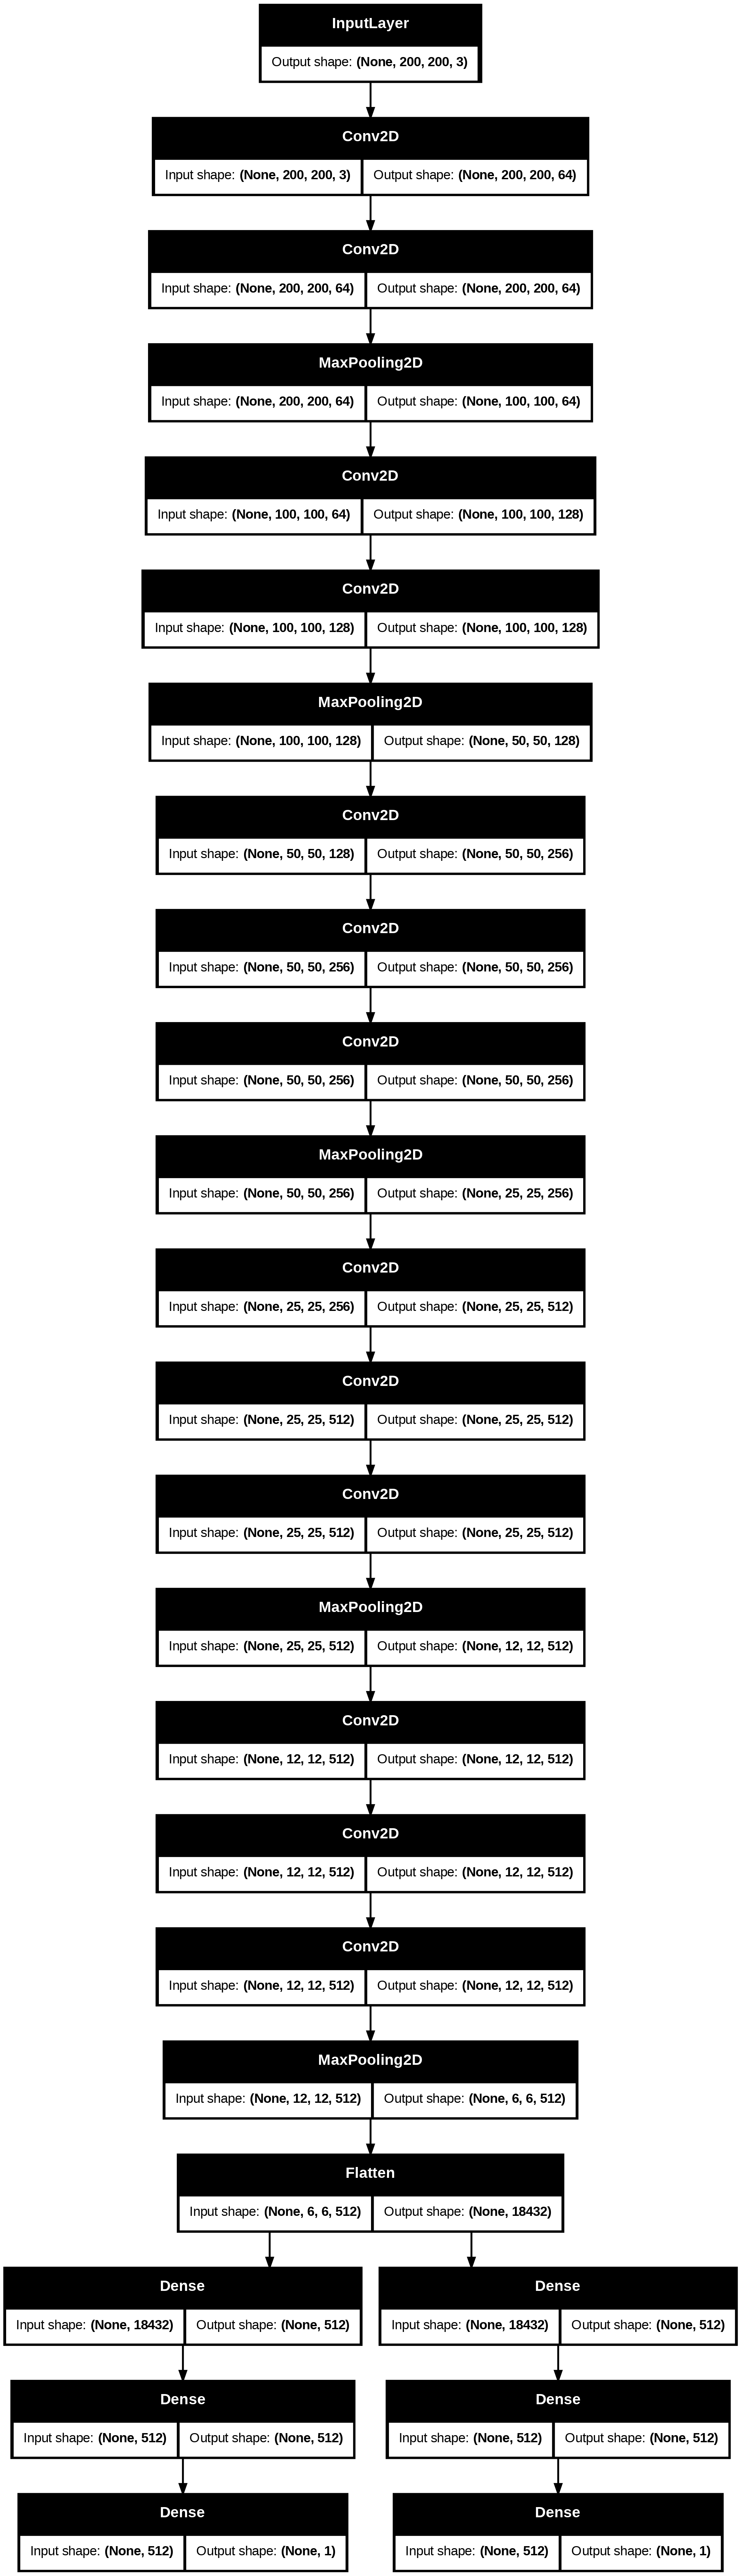

In [ ]:
from keras.utils import plot_model
#plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer='adam',loss = {'age':'mae','gender':'binary_crossentropy'},metrics = {'age':'mae','gender':'accuracy'})

In [ ]:
model.fit(train_generator,batch_size = 32,epochs = 10,validation_data= test_generator)

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [ ]:
resnet = ResNet50(include_top = False, input_shape=(200,200,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet.trainable = False
output = resnet.layers[-1].multi_output
flatten = Flatten()(output)
dense1 = Dense(512,activation = 'relu')(flatten)
dense2 = Dense(512,activation = 'relu')(flatten)

dense3 = Dense(512,activation = 'relu')(dense1)
dense4 = Dense(512,activation = 'relu')(dense2)

output1 = Dense(1,activation = 'linear',name = 'age')(dense3)